<a href="https://colab.research.google.com/github/sanazgit/Deep-Iearning-Projects/blob/main/L_Layer_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Implementing a flexible Neural Network**

In order for our implementation to be called flexible, we should be able to add/remove layers without changing the code. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
from math import log
from numpy import mean
from scipy.io import loadmat 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

* **Read data**

In [3]:
mat = loadmat('/content/drive/MyDrive/Colab Notebooks/Deep Learning/MultiClass-Problem-Train-Deep-1.mat')  # load mat-file
X_train = mat['All_Data']  # variable in mat file
y_train = mat['All_Labels']  # variable in mat file

In [4]:
mat_test = loadmat('/content/drive/MyDrive/Colab Notebooks/Deep Learning/MultiClass-Problem-Test-Deep-1.mat')  # load mat-file
X_test = mat_test['All_Data']  # variable in mat file
y_test = mat_test['All_Labels']  # variable in mat file

In [ ]:
X_train.shape

(1600, 5)

 * **Create a class that represents our network’s hidden and output layers.**

In [17]:
class L_layerDeepNetwork(object):

    def __init__(self, alpha=0.6, n_iteration=1000): 

      self.alpha = alpha                         
      self.n_iter = n_iteration

    def initialize_parameters_deep(self, layer_dims):
      
      np.random.seed(3)
    
      parameters = {}
      L = len(layer_dims)    # number of layers in the network

      for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l-1], layer_dims[l]) * 0.001
        parameters['b' + str(l)] = np.zeros(layer_dims[l])
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l-1], layer_dims[l]))
        #assert(parameters['b' + str(l)].shape == (layer_dims[l]))
        
      return parameters


    def sigmoid(self,Z):
      A = 1/(1+np.exp(-Z))
      cache = Z
      return A, cache

    def sigmoid_backward(self,cache):

      s = cache
      ds= s*(1-s)

      return ds

    def softmax(self, Z):
      expA = np.exp(Z)
      A= expA / expA.sum(axis=1, keepdims=True)
      cache = Z 
      return A, cache 

    # ==============  Forward Propagation  

    def linear_forward(self, A, W, b): # Linear Forward
      Z = np.dot(A, W) + b

      assert(Z.shape == (A.shape[0], W.shape[1])) # e.x---> w=(4,3), A=(5,3) , z(4,5)
      cache = (A, W, b)
    
      return Z, cache  
    
    def linear_activation_forward(self, A_prev, W, b, activation): # Linear-Activation Forward
      
      if activation == "sigmoid":
        Z, linear_cache = self.linear_forward(A_prev, W, b)
        A, activation_cache = self.sigmoid(Z)
    
      elif activation == "softmax":
        Z, linear_cache = self.linear_forward(A_prev, W, b)
        A, activation_cache = self.softmax(Z)
    
      assert (A.shape == (A_prev.shape[0], W.shape[1]))
      cache = (linear_cache, activation_cache)

      return A, cache

    def L_model_forward(self,X,Y, parameters):
      
      caches = []
      A = X
      
      L = len(parameters) // 2  # number of layers in the neural network
    
      for l in range(1, L):
        A_prev = A 
        A, cache = self.linear_activation_forward(A_prev, 
                                                  parameters['W' + str(l)], 
                                                  parameters['b' + str(l)], 
                                                  activation='sigmoid')
        caches.append(cache)
    
      AL, cache = self.linear_activation_forward(A, 
                                                 parameters['W' + str(L)], 
                                                 parameters['b' + str(L)], 
                                                 activation='softmax')
      caches.append(cache)
    
      #assert(AL.shape == (X.shape[0],Y.shape[1]))
            
      return AL, caches

    # Cost Function
    def compute_cost(self,AL, Y): 

      m = Y.shape[0]
      k= Y.shape[1]

      E= (-1/(m*k)) * np.sum(Y * np.log(AL))
    
      assert(E.shape == ())
    
      return E

   # ==================  Backward Propagation   
    # Linear backeard l=L

    def linear_last_backward(self,dE, cache):

      A_prev, W, b = cache[0]
      m = A_prev.shape[0]
      k = A_prev.shape[1]

      dW = (1 / (k*m)) * np.dot(A_prev.T,dE)   
      db = (1/(k*m))* np.sum(dE, axis=0, keepdims=True)
      
      ds= self.sigmoid_backward(cache[1])

      dA_prev = np.dot((dE * ds), W.T)

      assert (dA_prev.shape == A_prev.shape)
      assert (dW.shape == W.shape)

      return dA_prev, dW, db


    # Linear backward l<L
    def linear_backward(self,dA,dS, cache):  

      A_prev, W, b = cache[0]
      m = A_prev.shape[0]
      k = A_prev.shape[1]

      dE= dA*dS

      dW = (1 /(k*m)) * np.dot(A_prev.T,dE)  
      db = (1/(k*m)) * np.sum(dE, axis=0, keepdims=True)

      ds= self.sigmoid_backward(cache[1])

      dA_prev = np.dot((dA * ds), W.T)

      assert (dA_prev.shape == A_prev.shape)
      assert (dW.shape == W.shape)
      #assert (db.shape[1] == b.shape[0])
    
      return dA_prev, dW, db  


    # L-Model Backward
    def L_model_backward(self,AL, Y, caches): # L-Model Backward
      grads = {}
      L = len(caches) # the number of layers
      m = AL.shape[1]
      Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL

      error= AL-Y

      current_cache = caches[-1]
      grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = self.linear_last_backward(error, current_cache)
    
      dA_prev= grads["dA" + str(L)]

      for l in reversed(range(L-1)):
        dAL= dA_prev
        current_cache = caches[l]
        dA_prev, dW, db = self.linear_backward(dAL , self.sigmoid_backward(current_cache[1]), current_cache) ##### edited
        grads["dA" + str(l + 1)] = dA_prev
        grads["dW" + str(l + 1)] = dW
        grads["db" + str(l + 1)] = db
        
      return grads

    # Update parameters
    def update_parameters(self,parameters, grads, learning_rate):
      L = len(parameters) // 2 # number of layers in the neural network

      for l in range(L):
        parameters["W" + str(l+1)] = parameters['W' + str(l + 1)] - learning_rate * grads['dW' + str(l + 1)]
        parameters["b" + str(l+1)] = parameters['b' + str(l + 1)] - learning_rate * grads['db' + str(l + 1)]
        
      return parameters


    def fit(self, X, Y, layers_dims,print_cost=False):

      X, Y = shuffle(X, Y)

      encoder = OneHotEncoder(sparse=False)
      Y = encoder.fit_transform(Y)
 
      np.random.seed(1)
      costs = []    # keep track of cost
    
      self.parameters = self.initialize_parameters_deep(layers_dims)
     
      for i in range(0, self.n_iter):
        # Forward propagation: [LINEAR -> Sigmoid]*(L-1) -> LINEAR -> Softmax.
        AL, caches = self.L_model_forward(X,Y, self.parameters)
        
        # Compute cost
        cost = self.compute_cost(AL, Y)
    
        # Backward propagation
        grads = self.L_model_backward(AL, Y, caches)
 
        # Update parameters
        self.parameters = self.update_parameters(self.parameters, grads, self.alpha)

        costs.append(cost)
 
      # plot the cost
      plt.plot(np.squeeze(costs))
      plt.ylabel('cost')
      plt.xlabel('iterations (per tens)')
      plt.title("Learning rate =" + str(self.alpha))
      plt.show()
    
      return self


    # ================= Prediction
    def predict(self, X,y):
      
      A = X
      
      L = len(self.parameters) // 2  # number of layers in the neural network
    
      for l in range(1, L):
        A_prev = A 
        A, cache = self.linear_activation_forward(A_prev, 
                                                  self.parameters['W' + str(l)], 
                                                  self.parameters['b' + str(l)], 
                                                  activation='sigmoid')
    
      yhat, cache = self.linear_activation_forward(A,
                                                   self.parameters['W' + str(L)], 
                                                   self.parameters['b' + str(L)], 
                                                   activation='softmax') 
       #yhat, cash= self.L_model_forward(X,y,self.parameters)
      X_predicted= np.argmax(yhat,axis=1) 
      X_predicted +=1
      X_predicted= X_predicted.reshape(-1,1)

      return X_predicted  

    def score(self,X, y): #This function compares the predictd label with the actual label to find the model performance
      score = sum(self.predict(X,y) == y) / len(y)
      return score  


* **Evaluete the model with One_layer network**

      alpha=0.6, n_iteration=1000

In [8]:
layers_dims_one = [5,32]#  1-layer model

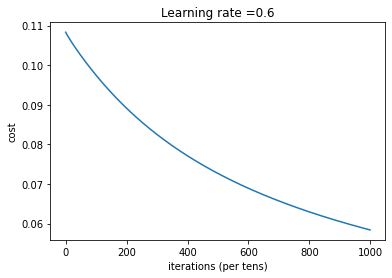

In [18]:
model_one=L_layerDeepNetwork().fit(X_train,y_train,layers_dims_one,print_cost=False)

In [31]:
print('Accuracy: %.2f%%' % (model_one.score(X_train,y_train) * 100))

Accuracy: 70.38%


In [30]:
print('Accuracy: %.2f%%' % (model_one.score(X_test,y_test) * 100))

Accuracy: 69.31%


In [22]:
model_one.parameters

{'W1': array([[-0.2247811 , -0.60682557, -0.57243425, -0.93693876, -0.74447622,
         -1.02080433, -1.00864952, -1.06237895, -0.62189448, -0.91633959,
         -0.98077966, -1.41521023, -0.94717284, -1.31369797, -1.3445643 ,
         -1.80495979,  1.86843803,  1.38504938,  1.26423538,  0.97551503,
          1.47974804,  0.97665323,  1.03562878,  0.57595949,  1.31687666,
          0.90029237,  0.81259199,  0.65567586,  0.92131539,  0.55774171,
          0.5303587 ,  0.26480164],
        [-0.09217536, -0.55360018, -0.66914092, -1.01500713, -0.57584941,
         -0.99553166, -0.93273974, -1.39544271,  1.87456312,  1.30953417,
          1.35502561,  0.94891833,  1.39085664,  0.88315124,  0.77085565,
          0.5465914 , -0.65231214, -0.99603202, -0.89449649, -1.32608835,
         -1.14861263, -1.27078631, -1.14488525, -1.59164902,  1.40298303,
          1.08005146,  0.97468237,  0.50949067,  0.89292697,  0.49751639,
          0.48267448,  0.32574683],
        [-0.03491428, -0.50964902,

* **Evaluete the model with 2_layers network**

In [24]:
layers_dims_one = [5,3,6,32]#  3-layer model

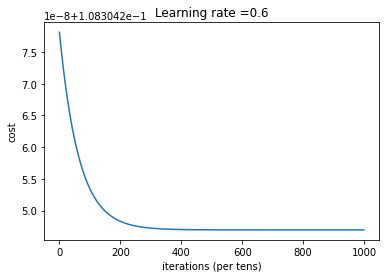

In [25]:
model_two=L_layerDeepNetwork().fit(X_train,y_train,layers_dims_one,print_cost=False)

In [29]:
print('Accuracy: %.2f%%' % (model_two.score(X_train,y_train) * 100))

Accuracy: 3.12%


In [28]:
print('Accuracy: %.2f%%' % (model_two.score(X_test,y_test) * 100))

Accuracy: 3.12%


**In my opinion, n_layer network is not suitable for this data model that we have.**

Check with MLPClassifier from sklearn:

In [32]:
from sklearn.neural_network import MLPClassifier

clf= MLPClassifier(solver='sgd', alpha=0.5, hidden_layer_sizes=(1,5), random_state=1, warm_start=True)

In [33]:
x,y= shuffle(X_train, y_train)
encoder = OneHotEncoder(sparse=False)
Y = encoder.fit_transform(y_train)
clf.fit(x,np.ravel(y))

MLPClassifier(alpha=0.5, hidden_layer_sizes=(1, 5), random_state=1,
              solver='sgd', warm_start=True)

In [35]:
clf.predict_proba(X_test)

array([[0.03416511, 0.02707192, 0.02510319, ..., 0.03317176, 0.03033267,
        0.02927304],
       [0.03416511, 0.02707192, 0.02510319, ..., 0.03317176, 0.03033267,
        0.02927304],
       [0.03416511, 0.02707192, 0.02510319, ..., 0.03317176, 0.03033267,
        0.02927304],
       ...,
       [0.03416511, 0.02707192, 0.02510319, ..., 0.03317176, 0.03033267,
        0.02927304],
       [0.03416511, 0.02707192, 0.02510319, ..., 0.03317176, 0.03033267,
        0.02927304],
       [0.03416511, 0.02707192, 0.02510319, ..., 0.03317176, 0.03033267,
        0.02927304]])

In [37]:
clf.score(X_test, y_test)

0.03125